In [8]:
#preparing 
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [11]:
#Part A: PCM Encoding (loading)
image = Image.open("cameraman.png").convert('L') #converting to grayscale if image is not
image = image.resize((256,256))

X = np.array(image, dtype = np.float64)
#normalizing
x = X / 255

M,N = X.shape
print("The size of the image is: ", M , "x", N)
print("The maximum and minimum pixel values of the image before normalization is: ",X.max(),",",X.min())
print("The maximum and minimum pixel values of the image after normalization is: ",x.max(),",",x.min())



The size of the image is:  256 x 256
The maximum and minimum pixel values of the image before normalization is:  253.0 , 7.0
The maximum and minimum pixel values of the image after normalization is:  0.9921568627450981 , 0.027450980392156862


In [55]:
#Part B: PCM Encoding (Quantization and Encoding)
def pcm_encoder(x,b):
    L = 2**b
    delta = 1/L

    #quantization index
    k = np.floor(x/delta).astype(int)
    k = np.clip(k,0,L-1) #clipping values for boundary conditions
    

    #reconstruction / dequantization
    x_hat = (k + 0.5)*delta

    #SQNR calculation
    SQNR = 10*np.log10(np.sum(x**2) / np.sum((x-x_hat)**2))

    #encoding the quantization index values
    bits = np.unpackbits(k.astype(np.uint8)[:,None],axis= 1)[:,-b:]  
    bitstream = bits.reshape(-1) #2D representation to 1D serially

    return k,x_hat,bitstream,SQNR

bit_list = [1,2,3,4,5,6,7,8]
for each_bit in bit_list:
    k,x_hat,bitstream,SQNR = pcm_encoder(x,each_bit)
    print("The bitstream length for b =",each_bit," is: ", each_bit*M*N)
    print("The SQNR value for b =",each_bit," is: ", SQNR,"\n")
    
    #print("The bitstream value for b =",each_bit," is: ", bits)

k,x_hat,bitstream,SQNR = pcm_encoder(x,4)
print("The value of k[i] for i = 10, and b = 4 is: ", k.flatten()[10],"\n")

k,x_hat,bitstream,SQNR = pcm_encoder(x,2)
print("The value of k[1:8] for b = 2 is: ", k.flatten()[1:8],"\n")
k,x_hat,bitstream,SQNR = pcm_encoder(x,8)
print("The value of k[1:8] for b = 8 is: ", k.flatten()[1:8],"\n")

    

The bitstream length for b = 1  is:  65536
The SQNR value for b = 1  is:  10.61475775706371 

The bitstream length for b = 2  is:  131072
The SQNR value for b = 2  is:  17.79545331225892 

The bitstream length for b = 3  is:  196608
The SQNR value for b = 3  is:  23.875608762915206 

The bitstream length for b = 4  is:  262144
The SQNR value for b = 4  is:  29.324246259143987 

The bitstream length for b = 5  is:  327680
The SQNR value for b = 5  is:  35.35957300326311 

The bitstream length for b = 6  is:  393216
The SQNR value for b = 6  is:  41.45526063241208 

The bitstream length for b = 7  is:  458752
The SQNR value for b = 7  is:  47.67040899216484 

The bitstream length for b = 8  is:  524288
The SQNR value for b = 8  is:  54.732440662564095 

The value of k[i] for i = 10, and b = 4 is:  9 

The value of k[1:8] and b = 2 is:  [2 2 2 2 2 2 2] 

The value of k[1:8] and b = 8 is:  [159 158 155 158 156 159 158] 



In [5]:
#Part A: PCM Encoding (loading)
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = cv2.imread("cameraman.png", cv2.IMREAD_GRAYSCALE)
M, N = img.shape

print("Image size:", M, "x", N)
print(img.max())
print(img.min())

x = img / 255

print(x.max())
print(x.min())
x_vec = x.flatten()

Image size: 256 x 256
253
7
0.9921568627450981
0.027450980392156862


In [6]:
#Part A: PCM Encoding (next task)
def pcm_encode(x, b):
    L = 2**b
    delta = 1/L
    k = np.floor(x/delta)
    k = np.clip(k, 0, L-1).astype(int)
    
    xcap = (k + 0.5)*delta
    Ps = np.mean(x**2)
    Pn = np.mean((x - xcap)**2)
    SQNRdB = 10*np.log10(Ps/Pn)
    
    
    bitstream="" #empty string to generate 0 or 1
    
    for v in k:
        bitstream+=np.binary_repr(v,width=b)  #representing the number in binary format
        
    b_tx = np.array(list(bitstream), dtype=np.uint8)  #numpy array of 0 and 1
    #separate each digit in the binary number and store as list contents
    
    return k, xcap, b_tx, SQNRdB



In [10]:
#Part B : Channels

#Channel A: Binary Symmetric Channel
            #(flips each bit independently with probability p: BER parameter)
            #rng: random number
def channel_bsc(b_tx, p, rng=None):
    if rng is None:
        rng = np.random.default_rng()
        
    z = (rng.random(b_tx.shape) < p).astype(np.uint8) #error mask
    b_rx = np.bitwise_xor(b_tx.astype(np.uint8), z)

    #measured BER
    ber_meas = np.mean(b_rx != b_tx)
    return b_rx, ber_meas

#Channel B: BPSK + AWGN : closer to physical link

def bpsk_modulate(b):
    b = b.astype(np.uint8)
    return 1 - 2*b # 0->1, 1->-1

def bpsk_demodulate(y):
    return (y > 0).astype(np.uint8)

def channel_awgn_bpsk(b_tx, ebn0_db):
    #signal to transmit symbols +1/-1
    s = bpsk_modulate(b_tx)
    ebn0 = 10**(ebn0_db/10) #log to linear
    Eb = 1
    N0 = Eb/ebn0    #noise spectral density
    sigma = np.sqrt(N0/2)
    
    #generating AWGN n
    n = np.random.normal(0,sigma,size=s.shape)
    y = s + n #received signal
    b_rx = bpsk_demodulate(y)
    #BER estimation
    ber = np.mean(b_rx != b_tx)
    return b_rx, ber


In [11]:
#Part C: PCM Decoder 
def pcm_decode(b_rx, b, M, N):
    L = 2**b
    delta = 1 / L
    total_bits = (len(b_rx) // b) * b
    b_rx = b_rx[:total_bits] #drops extra bits caused by channel truncation
    bits = b_rx.reshape(-1, b) #each row is one symbol

    #converting binary number into a digit in decimal rep
    k_hat = []
    for row in bits:
        binary_string = ""
        for bit in row:
            binary_string += str(bit)
        index = int(binary_string, 2)
        k_hat.append(index)

    #mid-rise reconstruction    
    k_hat = np.array(k_hat)
    k_hat = np.clip(k_hat, 0, L-1)
    xcap = (k_hat + 0.5) * delta
    xcap_img = xcap.reshape(M, N)
    
    return xcap_img

def compute(x, x_hat):

    #mean squared error
    mse = np.mean((x - x_hat)**2)
    Ps = np.mean(x**2)
    snr_db = 10*np.log10(Ps/mse)
    maximum = 1 #max pixel value = 1
    psnr_db = 10*np.log10(maximum**2/mse)
    
    return mse, snr_db, psnr_db

========b = 1 ========
NO CHANNEL
b=1 	 MSE=0.024 	 SNR=10.615 	 PSNR=16.197 
BSC
b=1 	 MSE=0.026 	 SNR=10.268 	 PSNR=15.851 	 BER=0.0102081
AWGN
b=1 	 MSE=0.141 	 SNR=2.936 	 PSNR=8.518 	 BER=0.4040070 


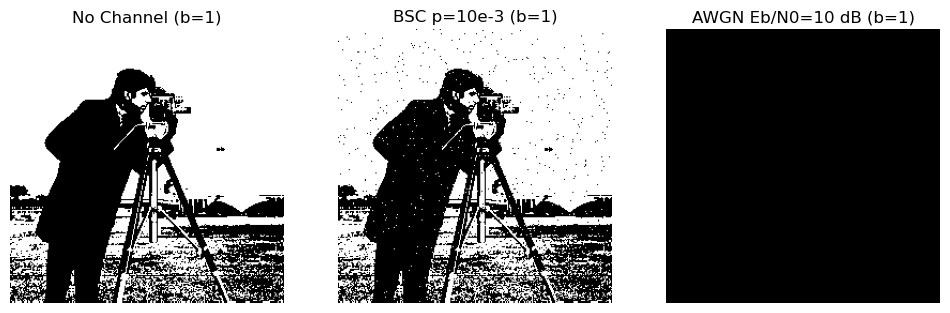

========b = 2 ========
NO CHANNEL
b=2 	 MSE=0.005 	 SNR=17.795 	 PSNR=23.378 
BSC
b=2 	 MSE=0.008 	 SNR=15.422 	 PSNR=21.004 	 BER=0.0104675
AWGN
b=2 	 MSE=0.227 	 SNR=0.850 	 PSNR=6.432 	 BER=0.6133652 


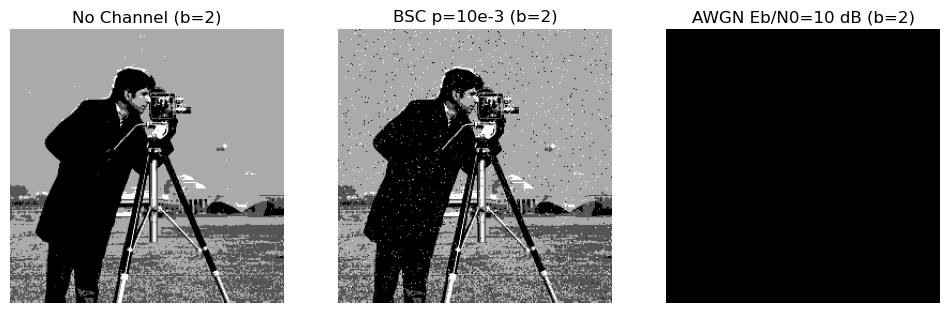

========b = 3 ========
NO CHANNEL
b=3 	 MSE=0.001 	 SNR=23.876 	 PSNR=29.458 
BSC
b=3 	 MSE=0.005 	 SNR=17.756 	 PSNR=23.339 	 BER=0.0103760
AWGN
b=3 	 MSE=0.282 	 SNR=-0.092 	 PSNR=5.490 	 BER=0.5705821 


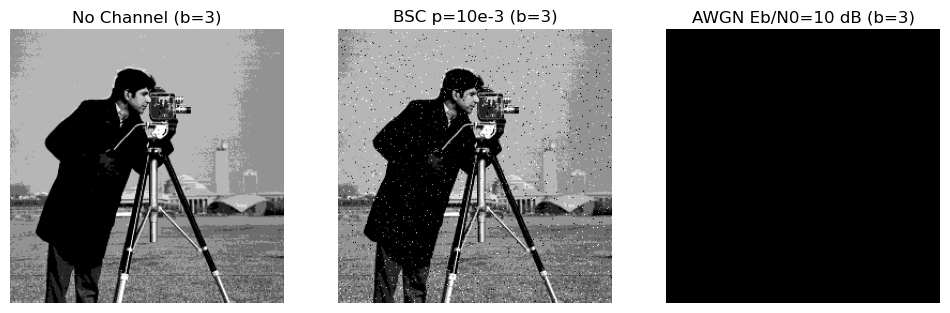

========b = 4 ========
NO CHANNEL
b=4 	 MSE=0.000 	 SNR=29.324 	 PSNR=34.907 
BSC
b=4 	 MSE=0.003 	 SNR=19.054 	 PSNR=24.636 	 BER=0.0099716
AWGN
b=4 	 MSE=0.313 	 SNR=-0.537 	 PSNR=5.045 	 BER=0.5712700 


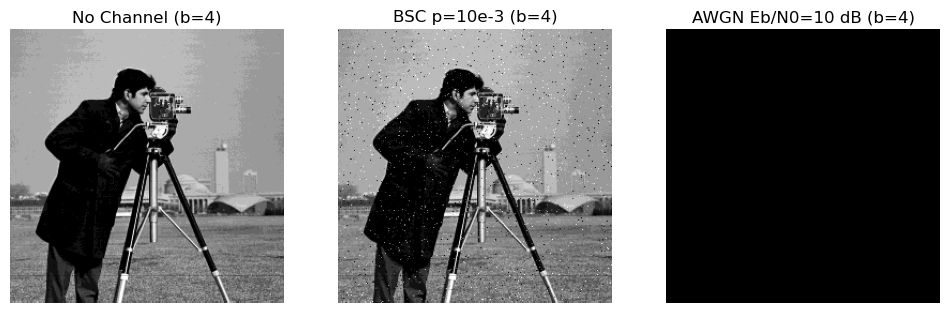

========b = 5 ========
NO CHANNEL
b=5 	 MSE=0.000 	 SNR=35.360 	 PSNR=40.942 
BSC
b=5 	 MSE=0.003 	 SNR=19.016 	 PSNR=24.598 	 BER=0.0101807
AWGN
b=5 	 MSE=0.329 	 SNR=-0.753 	 PSNR=4.829 	 BER=0.5493195 


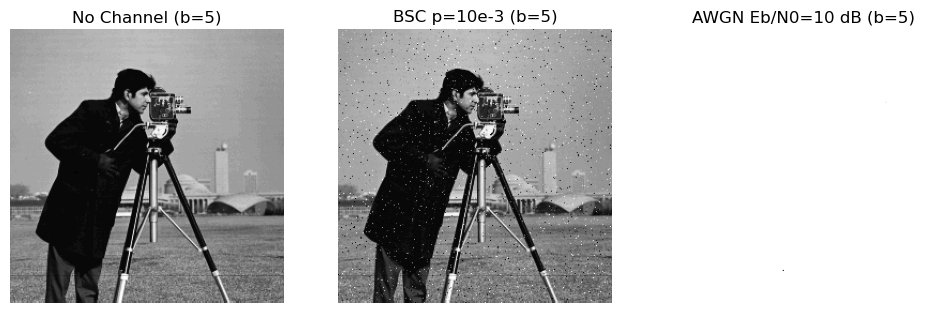

========b = 6 ========
NO CHANNEL
b=6 	 MSE=0.000 	 SNR=41.455 	 PSNR=47.038 
BSC
b=6 	 MSE=0.003 	 SNR=19.090 	 PSNR=24.673 	 BER=0.0098445
AWGN
b=6 	 MSE=0.337 	 SNR=-0.860 	 PSNR=4.723 	 BER=0.5415955 


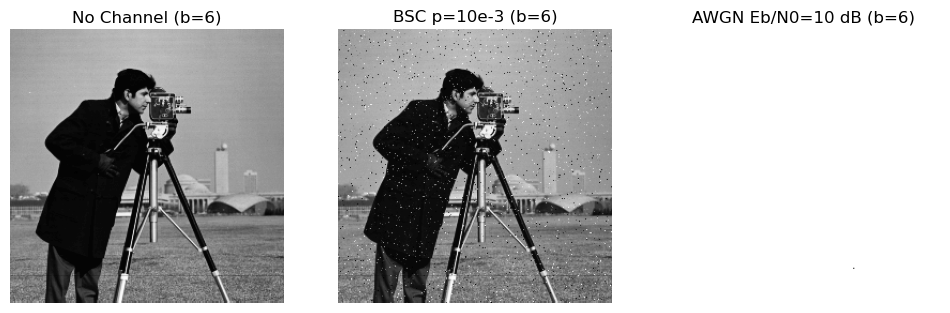

========b = 7 ========
NO CHANNEL
b=7 	 MSE=0.000 	 SNR=47.670 	 PSNR=53.253 
BSC
b=7 	 MSE=0.003 	 SNR=19.015 	 PSNR=24.598 	 BER=0.0100098
AWGN
b=7 	 MSE=0.341 	 SNR=-0.913 	 PSNR=4.670 	 BER=0.5362004 


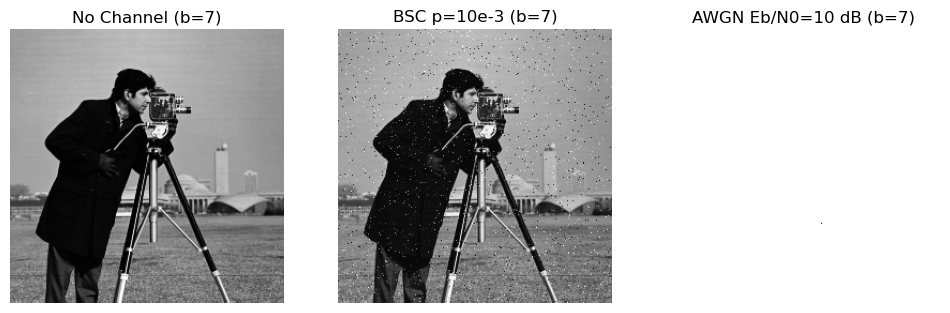

========b = 8 ========
NO CHANNEL
b=8 	 MSE=0.000 	 SNR=54.732 	 PSNR=60.315 
BSC
b=8 	 MSE=0.003 	 SNR=19.004 	 PSNR=24.587 	 BER=0.0099792
AWGN
b=8 	 MSE=0.343 	 SNR=-0.939 	 PSNR=4.643 	 BER=0.5320015 


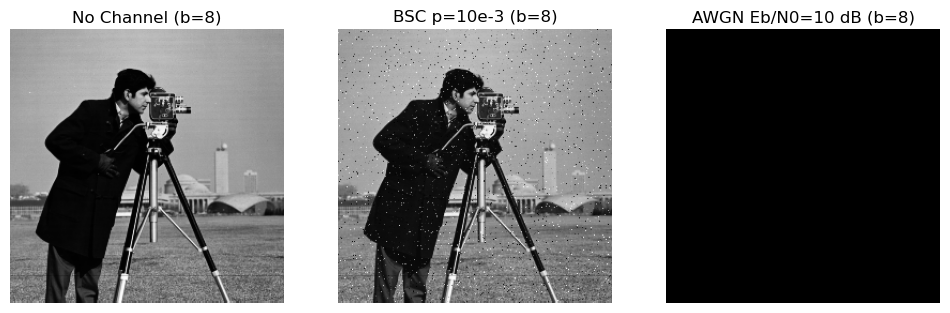

In [12]:
#Main function

b_list = range(1,9) #bits/sample
SQNR_list = []

PSNR_noch = []
PSNR_bsc = []
PSNR_awgn = []

SNR_noch = []
SNR_bsc = []
SNR_awgn = []

BER_bsc = []
BER_awgn = []

p = 10e-3
ebn0_db = 10

for b in b_list:
    #Encoder
    k, xq, b_tx, SQNRdB = pcm_encode(x_vec, b)
    SQNR_list.append(SQNRdB)
    
    #No channel
    x_hat_img = xq.reshape(M,N)
    mse, snr, psnr = compute(x, x_hat_img)
    PSNR_noch.append(psnr)
    SNR_noch.append(snr)
    
    #BSC channel
    b_rx_bsc, ber_bsc = channel_bsc(b_tx, p)
    x_bsc = pcm_decode(b_rx_bsc, b, M, N)
    mse_bsc,snr_bsc, psnr_bsc = compute(x, x_bsc)
    PSNR_bsc.append(psnr_bsc)
    SNR_bsc.append(snr_bsc)
    BER_bsc.append(ber_bsc)
    
    #AWGN channel
    b_rx_awgn, ber_awgn = channel_awgn_bpsk(b_tx, ebn0_db)
    x_awgn = pcm_decode(b_rx_awgn, b, M, N)
    mse_awgn, snr_awgn, psnr_awgn = compute(x, x_awgn)
    PSNR_awgn.append(psnr_awgn)
    SNR_awgn.append(snr_awgn)
    BER_awgn.append(ber_awgn)

    print(f"========b = {b} ========")
    print("NO CHANNEL")
    print(f"b={b} \t MSE={mse:.3f} \t SNR={snr:.3f} \t PSNR={psnr:.3f} ")
    print("BSC")
    print(f"b={b} \t MSE={mse_bsc:.3f} \t SNR={snr_bsc:.3f} \t PSNR={psnr_bsc:.3f} \t BER={ber_bsc:.7f}")
    print("AWGN")
    print(f"b={b} \t MSE={mse_awgn:.3f} \t SNR={snr_awgn:.3f} \t PSNR={psnr_awgn:.3f} \t BER={ber_awgn:.7f} ")
    if b in range(1, 9):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(x_hat_img, cmap='gray')
        plt.title(f"No Channel (b={b})")
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(x_bsc, cmap='gray')
        plt.title(f"BSC p=10e-3 (b={b})")
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(x_awgn, cmap='gray')
        plt.title(f"AWGN Eb/N0=10 dB (b={b})")
        plt.axis('off')
        plt.show()

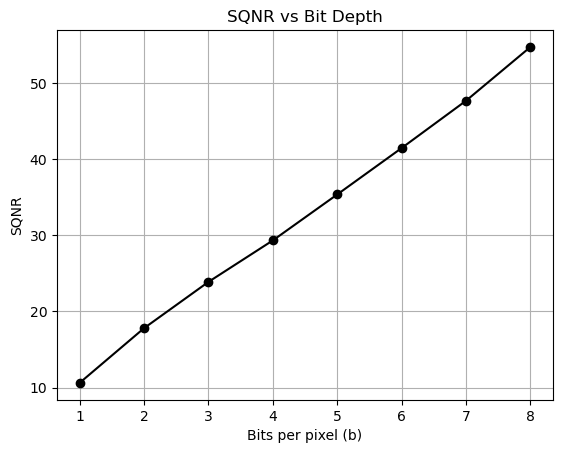

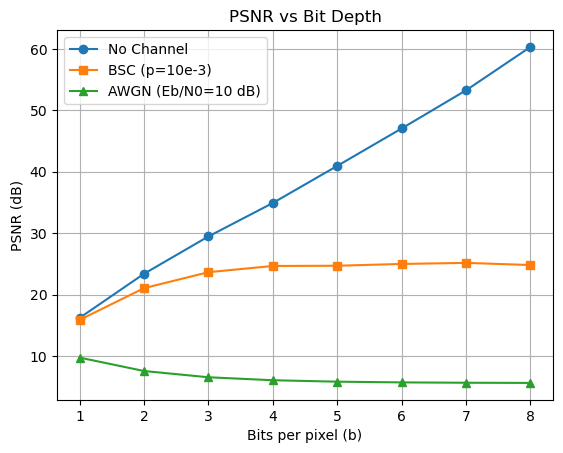

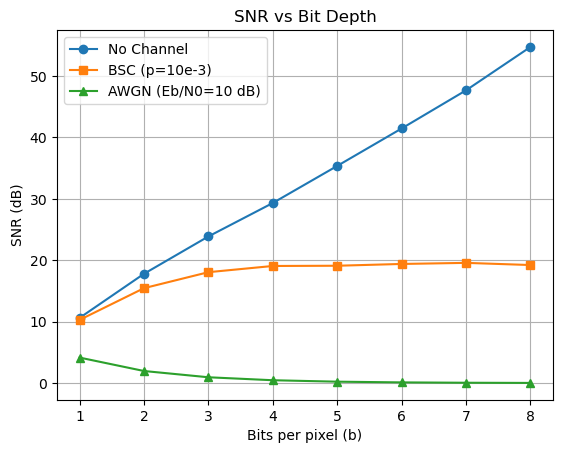

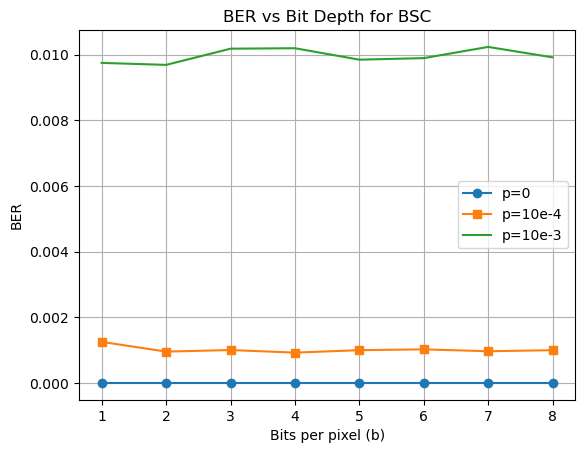

In [38]:
#plots

#SQNR vs Bit Depth
SQNR_list = []
b_vals = np.arange(1, 9)

for b in b_vals:
    _,_,_,sqnr = pcm_encode(x_vec, b)
    SQNR_list.append(sqnr)
    
plt.figure()
plt.plot(b_vals, SQNR_list, 'o-',color='k')
plt.xlabel("Bits per pixel (b)")
plt.ylabel("SQNR")
plt.title("SQNR vs Bit Depth")
plt.grid()
plt.show()

#PSNR vs Bit Depth
b_vals = np.arange(1, 9)

plt.plot(b_vals, PSNR_noch, 'o-', label="No Channel")
plt.plot(b_vals, PSNR_bsc, 's-', label="BSC (p=10e-3)")
plt.plot(b_vals, PSNR_awgn, '^-', label="AWGN (Eb/N0=10 dB)")
plt.xlabel("Bits per pixel (b)")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs Bit Depth")
plt.legend()
plt.grid()
plt.show()

#SNR vs Bit Depth
plt.plot(b_vals, SNR_noch, 'o-', label="No Channel")
plt.plot(b_vals, SNR_bsc, 's-', label="BSC (p=10e-3)")
plt.plot(b_vals, SNR_awgn, '^-', label="AWGN (Eb/N0=10 dB)")
plt.xlabel("Bits per pixel (b)")
plt.ylabel("SNR (dB)")
plt.title("SNR vs Bit Depth")
plt.legend()
plt.grid()
plt.show()

# BSC (BER v/s P)
p_values = [0, 10e-4, 10e-3]
BER_bsc = []
for p in p_values:
    for b in range(1, 9):
    
        # Encoder
        k, xq, b_tx, SQNRdB = pcm_encode(x_vec, b)
    
        # BSC channel
        b_rx_bsc, ber_bsc = channel_bsc(b_tx, p)
        x_bsc = pcm_decode(b_rx_bsc, b, M, N)
        mse_bsc,snr_bsc, psnr_bsc = compute(x, x_bsc)
        BER_bsc.append(ber_bsc)

#print(len(SQNR_list))
b_vals = np.arange(1, 9)
plt.plot(b_vals, BER_bsc[:8], 'o-', label="p=0")
plt.plot(b_vals, BER_bsc[8:8+8], 's-', label="p=10e-4")
plt.plot(b_vals, BER_bsc[16:], '-', label="p=10e-3")
plt.xlabel("Bits per pixel (b)")
plt.ylabel("BER")
plt.title("BER vs Bit Depth for BSC")
plt.legend()
plt.grid()
plt.show()
